# Plotting of pretrained results


In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from master_models.pretrained import pretrained_model
%load_ext autoreload
%autoreload 2


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [3]:

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events

# Flag import, since we can now import 200k events from .npy files
from_file = False
if from_file:

    folder = "simulated"
    filename = "CeBr2Mil_Mix.txt"
    num_samples = 2e5
    #folder = "sample"
    #filename = "CeBr10k_1.txt"
    #num_samples = 1e3

    data = import_data(folder=folder, filename=filename, num_samples=num_samples)
    images = data[filename]["images"]
    energies = data[filename]["energies"]
    positions = data[filename]["positions"]
    labels = to_categorical(data[filename]["labels"])
    n_classes = labels.shape[1]
else:
    images = load_feature_representation("images_200k.npy")
    energies = load_feature_representation("energies_200k.npy")
    positions = load_feature_representation("positions_200k.npy")
    labels = load_feature_representation("labels_200k.npy")

n_classes = labels.shape[1]
print("Number of classes: {}".format(n_classes))
print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))


Number of classes: 2
Images shape: (199998, 16, 16, 3)
Energies shape: (199998, 2)
Positions shape: (199998, 4)
Labels shape: (199998, 2)


## Classification with custom dense network
### Multiple dense model
Build a dense model for each pretrained model form which a feature representation has been saved.

In [3]:
# Keys: model names, Values: depth to compare at.
pretrained_models = {
    "DenseNet121":None, #8
    "DenseNet169":None, #8
    "DenseNet201":None, #8
    "InceptionResNetV2":None, #8
    "InceptionV3":None, #8
    "MobileNet":None, #8
    "MobileNetV2":None, #5
    "NASNetLarge":None, #4
    "NASNetMobile":None, #4
    "ResNet50":None, #8
    "VGG16":None,
    "VGG19":None,
    "Xception":None, #6
    }

# Load model

In [61]:
MODEL_PATH = "../../data/output/models/"
name = "DenseNet201-0.94.hdf5"

loaded_model = tf.keras.models.load_model(MODEL_PATH+name)

# Load feature representation
net = "DenseNet201"
depth = "full"
epochs = 5
# Load features
features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + ".npy"
pretrained_features = load_feature_representation(features_filename)

labels_positions_energies = np.concatenate((labels, positions, energies), axis=1)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(pretrained_features, labels_positions_energies, test_size = 0.2)    

test_positions = y_test[:, 2:6]
train_positions = y_train[:, 2:6]
test_energies = y_test[:, 6:]
train_energies = y_train[:, 6:]
y_test = y_test[:, :2]
y_train = y_train[:, :2]

tmp_predicted = loaded_model.predict(x_test)
tmp_results = tmp_predicted.argmax(axis=-1).reshape(tmp_predicted.shape[0], 1)

# indices, relative distances and relative energies for test set
single_indices, double_indices, close_indices = event_indices(test_positions)
rel_distance_test = relative_distance(test_positions)
rel_energy_test = relative_energy(test_energies)

# Separate correct and wrong classifications


correct_doubles = np.where(tmp_results[double_indices] == 1)[0]
wrong_doubles = np.where(tmp_results[double_indices] == 0)[0]

mean_correct = np.mean(rel_distance_test[double_indices][correct_doubles])
mean_wrong = np.mean(rel_distance_test[double_indices][wrong_doubles])
mean_all = np.mean(rel_distance_test[double_indices])

ratio_doubles = len(correct_doubles) / len(double_indices)

# Ratio of correctly classified double events with a distance between
# events < 3mm
n_close = len(close_indices)
n_close_correct = len(np.where(rel_distance_test[double_indices][correct_doubles] < 3.0)[0])
ratio_close = n_close_correct / n_close
print(len(correct_doubles))
print(len(wrong_doubles))

# Output
print("Mean dist all double events: ", mean_all)
print("Mean dist correct double events: ", mean_correct)
print("Mean dist wrong double events: ", mean_wrong)
print("Ratio of correctly classified double events: ", ratio_doubles)
print("Ratio correctly classified events with dist < 3mm: ", ratio_close)

17828
2197
Mean dist all double events:  7.648718397438232
Mean dist correct double events:  7.965861615413739
Mean dist wrong double events:  5.075195734685687
Ratio of correctly classified double events:  0.8902871410736579
Ratio correctly classified events with dist < 3mm:  0.6419811320754717


# Plots

## Accuracy and loss

In [62]:
acc_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_accuracy"
loss_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_loss"

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(acc_filename)
plt.clf()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(loss_filename)
plt.clf()
    


NameError: name 'history' is not defined

## Confusion Matrix

Confusion matrix, without normalization
[[19833   142]
 [ 2197 17828]]


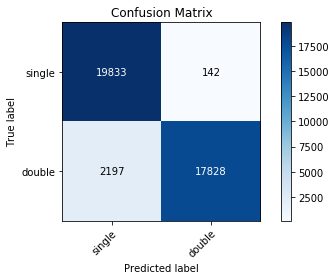

In [63]:
from analysis_functions.plotting import plot_confusion_matrix
classes = ["single", "double"]
title = "Confusion Matrix"
plot_confusion_matrix(y_test.argmax(axis=-1), tmp_results, classes, title=title)

## Histograms

### Test set correct/wrong

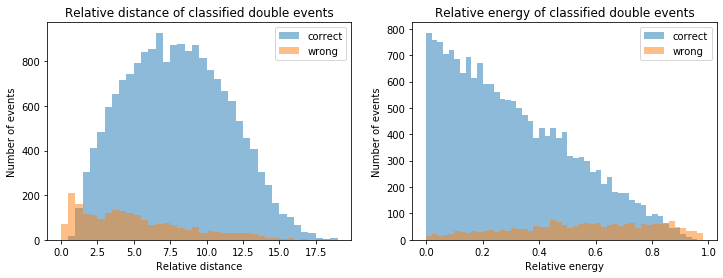

In [83]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, np.amax(rel_energy_test), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Relative distance of classified double events")
ax[0].set_xlabel("Relative distance")
ax[0].set_ylabel("Number of events")
ax[0].legend()
ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].set_title("Relative energy of classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()


Text(0.5, 0, 'Relative energy')

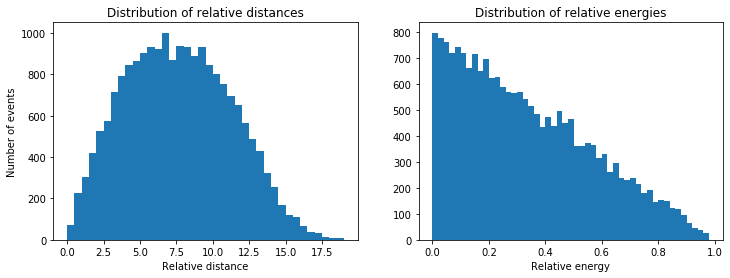

In [67]:
# Look at the general distribution of relative distances and energy.
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, np.amax(rel_energy_test), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_test[double_indices], bins=dist_bins)
ax[0].set_title("Distribution of relative distances in test set")
ax[0].set_xlabel("Relative distance")
ax[0].set_ylabel("Number of events")
ax[1].hist(rel_energy_test[double_indices], bins=energy_bins)
ax[1].set_title("Distribution of relative energies in test set")
ax[1].set_xlabel("Relative energy")

### Distribution for the full dataset (200k)

W0927 18:33:12.634444 139661016946496 legend.py:1282] No handles with labels found to put in legend.
W0927 18:33:12.675549 139661016946496 legend.py:1282] No handles with labels found to put in legend.


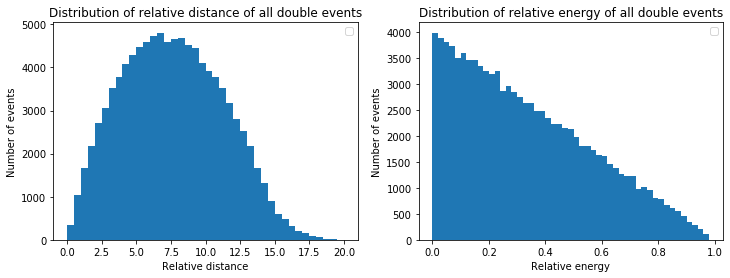

In [80]:
# Histograms
dist_bins = np.arange(0, np.amax(rel_distance_all), 0.5)
energy_bins = np.arange(0, np.amax(rel_energy_all), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_all, bins=dist_bins)
ax[0].set_title("Distribution of relative distance of all double events")
ax[0].set_xlabel("Relative distance")
ax[0].set_ylabel("Number of events")
ax[0].legend()

ax[1].hist(rel_energy_all, bins=energy_bins)
ax[1].set_title("Distribution of relative energy of all double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()

## Plots of events that no networks were able to classify correctly

In [68]:
# Load indices
OUTPUT_PATH = MODEL_PATH = "../../data/output/"
fname_indices = "never_correct_indices.txt"
never_correct = np.loadtxt(OUTPUT_PATH + fname_indices, dtype=int).tolist()

rel_distance_never = relative_distance(positions[never_correct])
rel_energy_never = relative_energy(energies[never_correct])

rel_distance_all = relative_distance(positions)
rel_energy_all = relative_energy(energies)

W0927 18:32:10.793348 139661016946496 legend.py:1282] No handles with labels found to put in legend.
W0927 18:32:10.832391 139661016946496 legend.py:1282] No handles with labels found to put in legend.


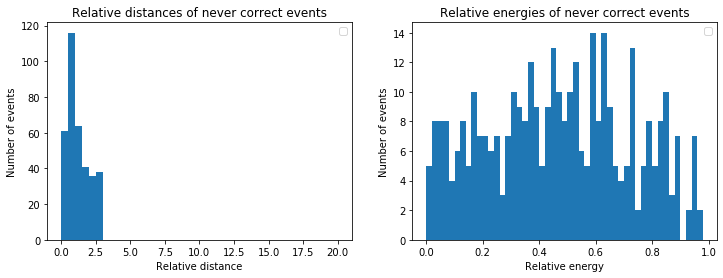

In [77]:
# Histograms
dist_bins = np.arange(0, np.amax(rel_distance_all), 0.5)
energy_bins = np.arange(0, np.amax(rel_energy_all), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_all[never_correct], bins=dist_bins)
ax[0].set_title("Relative distances of never correct events")
ax[0].set_xlabel("Relative distance")
ax[0].set_ylabel("Number of events")
ax[0].legend()

ax[1].hist(rel_energy_all[never_correct], bins=energy_bins)
ax[1].set_title("Relative energies of never correct events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()

(356, 16, 16)


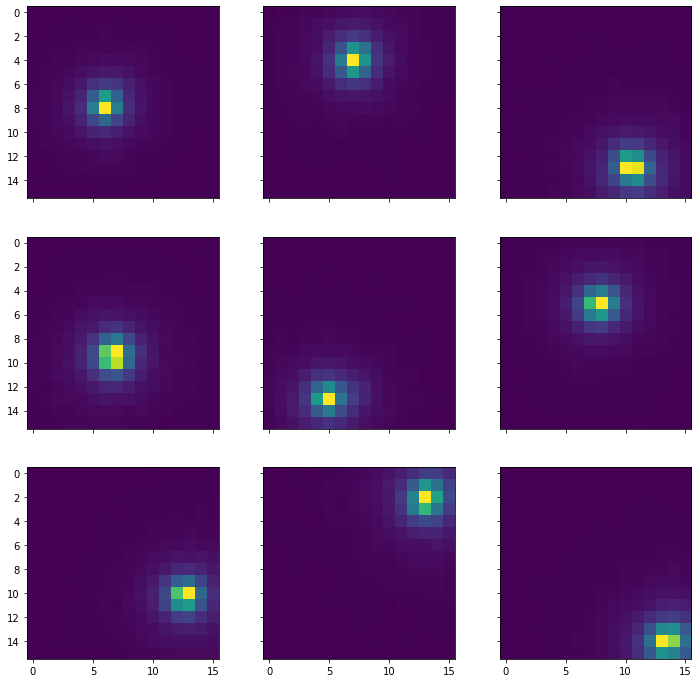

In [81]:
images_plot = images[never_correct][:,:,:,0]
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
index = 120
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(images_plot[index + i*3 + j])
        

        

In [ ]:
# Plot some images, with electron origin positions
%matplotlib inline

images = images.reshape(images.shape[0],16,16)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
for i in range(3):
    for j in range(3):
        # plot image
        ax[i, j].imshow(images[index + i*3 + j])
        
        # plot origin of event
        x = positions[index + i*3 + j, 0]
        y = positions[index + i*3 + j, 1]
        ax[i, j].plot(x, y, 'rx')
        ax[i, j].set_title('single')
        if positions[index + i*3 + j, 3] != -100:
            x2 = positions[index + i*3 + j, 2]
            y2 = positions[index + i*3 + j, 3]
            ax[i, j].plot(x2, y2, 'rx')
            ax[i, j].set_title('double')
        
plt.show()